#Problem 3: Learning a data-driven Linear Dynamical System (LDS)

##Part D:
The learned dynamics should provide a projection of the data onto a given space. Take one of the first 6 datapoints in each dataset in the jPCA datasets, and use the learned dynamics from Part C to extrapolate the neural system forward in time. Plot the first two dynamical principal dimensions of the projection: how do they look?

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


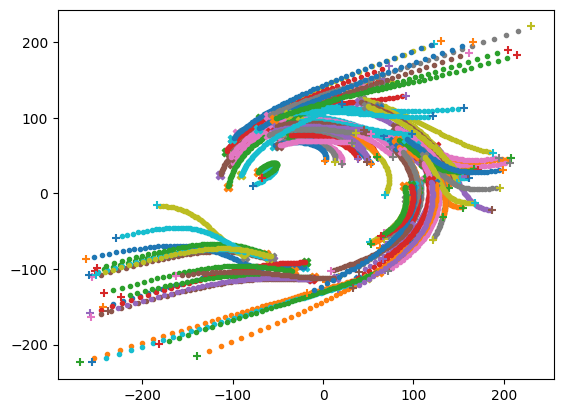

In [ ]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Find the file in google drive
drive.mount('/content/drive')
file = "/content/drive/MyDrive/Neural_Signals_and_Computation_HW2/exampleData.mat"

import scipy.io as sio
mat_contents = sio.loadmat(file)
data = mat_contents['Data']
# Data is the struct (length = 1)
# Data[c] is the condition (length = 108)
# Data[c][o] are the fields options (length = 2)
# Data[c][o][0] is the A matrix (shape = (61, 218))
# Data[c][o][1] is the time (shape = (61, 1))

# Repeat what we did in B, use PCA on data matrix before dynamics analysis
def do_pca(data_matrix, num_components=6):
  pca = PCA(n_components=num_components)
  data_mean = np.mean(data_matrix, axis=0)
  data_centered = data_matrix - data_mean
  data_reduced = pca.fit_transform(data_centered)
  return data_reduced, pca, data_mean

# Now for k datasets
dx_dt = []
xt = []

conds = []
pcas = []
means = []
times = []
for k in range(len(data[0])):
  condition_k = data[0][k]
  cond_A, pca_k, mean_k = do_pca(condition_k[0])
  cond_A = cond_A.transpose()
  conds.append(cond_A)
  pcas.append(pca_k)
  means.append(mean_k)
  cond_t = condition_k[1]
  times.append(cond_t)

  for i in range(cond_A.shape[1] - 1):
    current = cond_A[:,i + 1]
    prev = cond_A[:,i]
    current_t = cond_t[i + 1]
    prev_t = cond_t[i]

    dx_dt.append((current - prev) / (current_t - prev_t))
    xt.append(current)

xt = np.array(xt)
dx_dt = np.array(dx_dt)

A_estimated_k = np.linalg.lstsq(xt, dx_dt, rcond=None)[0]

# Extrapolation
extrapolations = []
for i in range(len(data[0])):
  cond_A = conds[i]
  pca = pcas[i]
  mean = means[i]
  cond_t = times[i]

  last_state = cond_A[:,0]
  extract_k = []
  for t in range(1, cond_A.shape[1]):
    x_pred = last_state + (cond_t[t] - cond_t[t-1]) * np.matmul(A_estimated_k, last_state)
    last_state = x_pred
    # Look at first two principal components in dynamical system
    extract_k.append((x_pred[0], x_pred[1]))
  extrapolations.append(extract_k)

# Plot Extrapolations
plt.figure()
for i in range(len(data[0])):
  current_extract = extrapolations[i]
  dim1 = []
  dim2 = []
  for j in range(1, len(current_extract) - 1):
    dim1.append(current_extract[j][1])
    dim2.append(current_extract[j][0])
  plt.scatter(current_extract[0][1], current_extract[0][0], marker='X')
  plt.scatter(dim1,dim2, marker='.')
  plt.scatter(current_extract[len(current_extract) - 1][1], current_extract[len(current_extract) - 1][0], marker='+')

Plotting the first two principal components, we can see a spiral pattern as shown before in the notes/paper for jPCA with the beginning of the spiral starting in the centerish and going out in a rotation.